
Preparing category: Commit Sharings
	Reading File: c:\Projects\software-engineering-project/src/raw_datasets\snapshot_20230727\20230727_200003_commit_sharings.json
	Reading File: c:\Projects\software-engineering-project/src/raw_datasets\snapshot_20230803\20230803_095317_commit_sharings.json
	Reading File: c:\Projects\software-engineering-project/src/raw_datasets\snapshot_20230810\20230810_124807_commit_sharings.json
	Reading File: c:\Projects\software-engineering-project/src/raw_datasets\snapshot_20230817\20230817_131244_commit_sharings.json
	Reading File: c:\Projects\software-engineering-project/src/raw_datasets\snapshot_20230824\20230824_102435_commit_sharings.json
	Reading File: c:\Projects\software-engineering-project/src/raw_datasets\snapshot_20230831\20230831_063412_commit_sharings.json
	Reading File: c:\Projects\software-engineering-project/src/raw_datasets\snapshot_20230907\20230907_110036_commit_sharings.json
	Reading File: c:\Projects\software-engineering-project/src/raw_dat

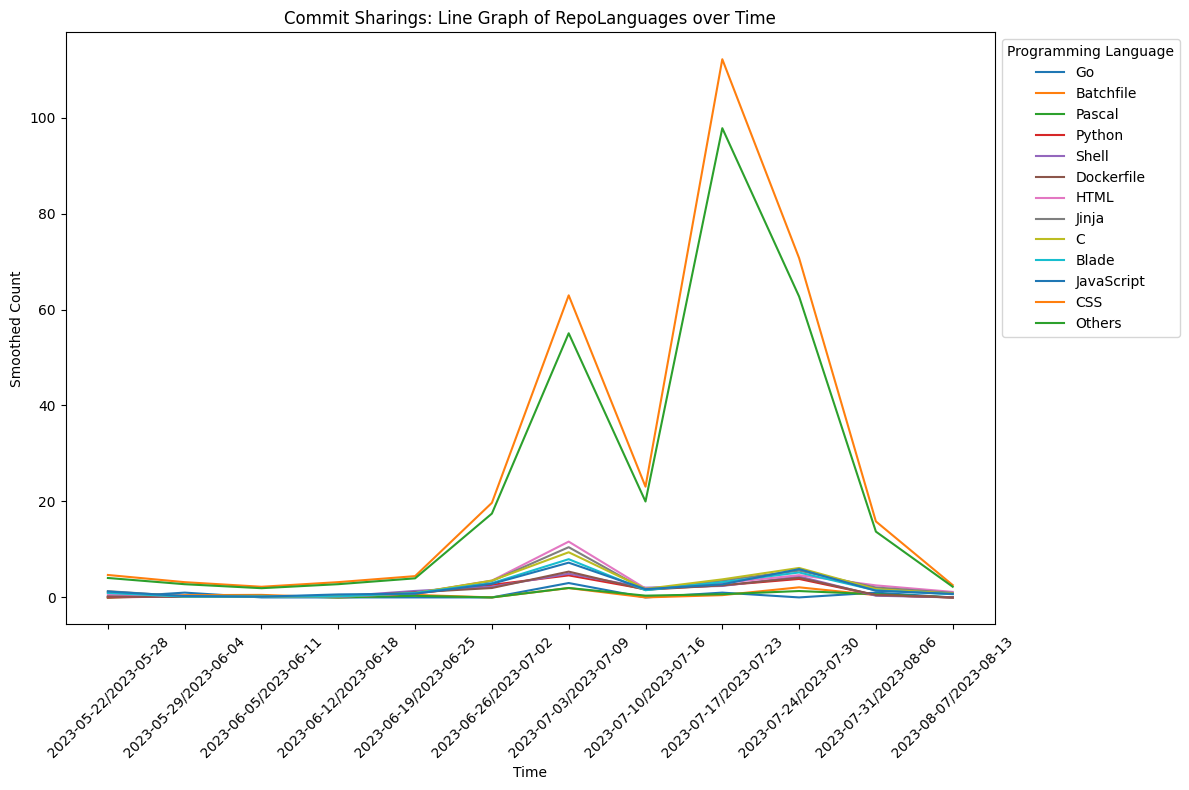

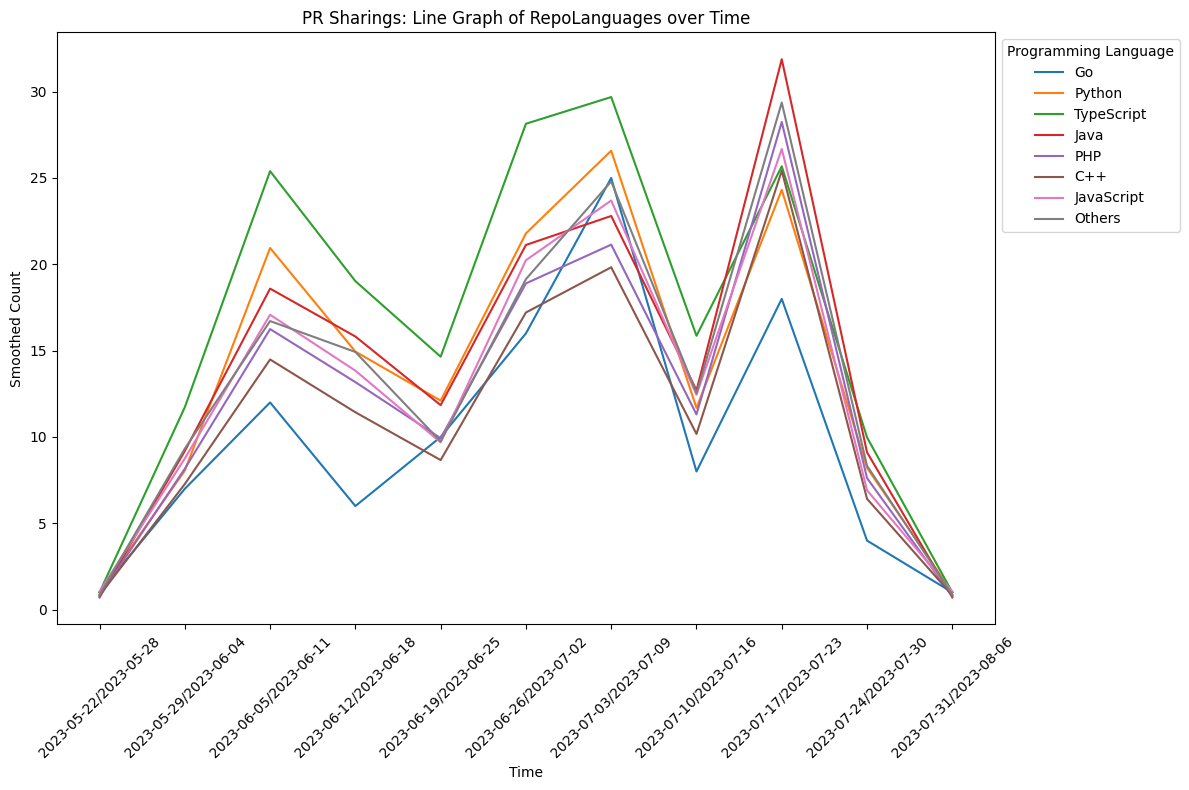

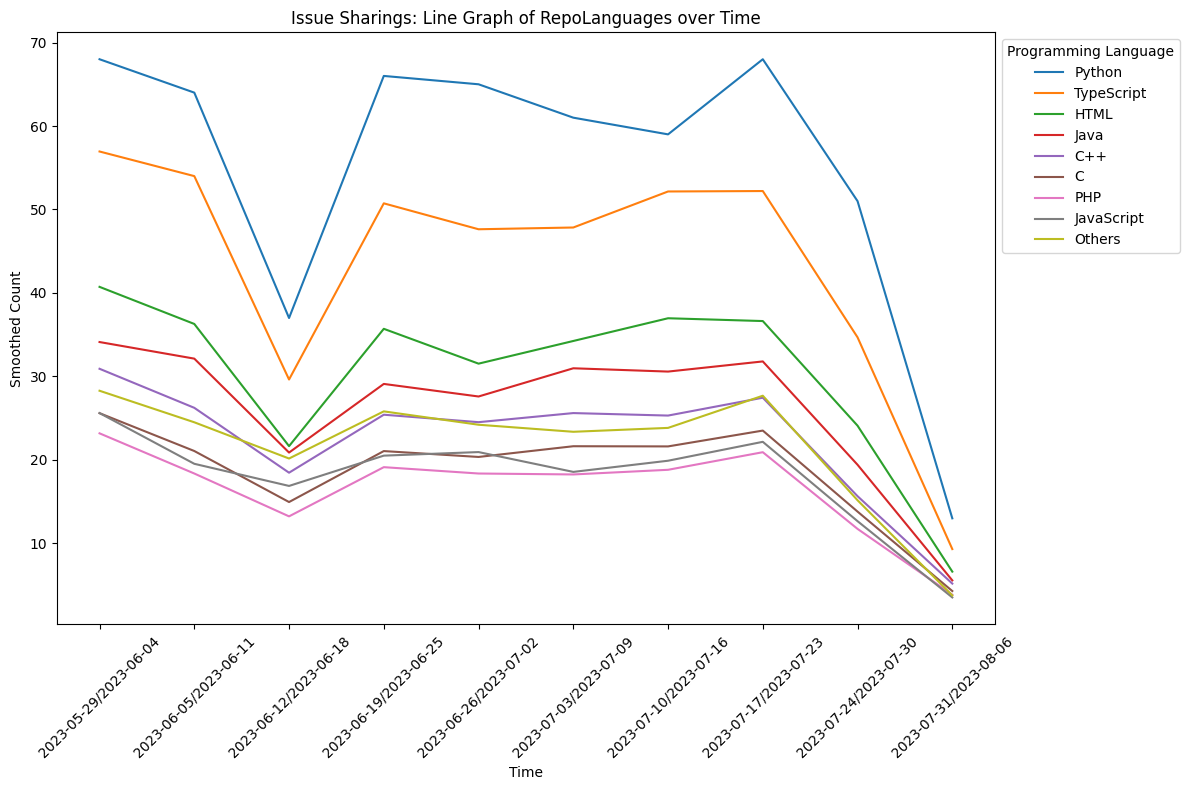

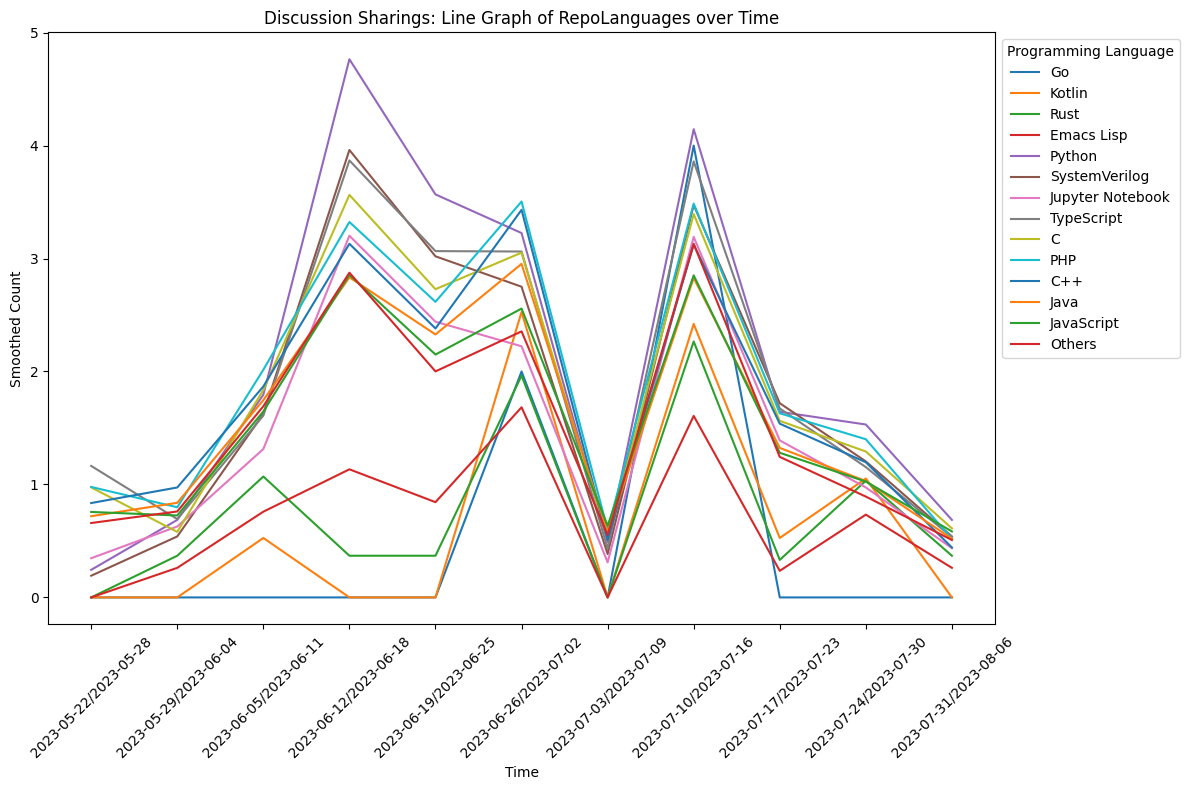

In [2]:
# Research question 2.

# Which programming languages do developers ask ChatGPT for
# help with, and how does this pattern change over time?

import os
import json
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt

CURRENT_DIRECTORY = os.getcwd().replace('/src/scripts','').replace('\\src\\scripts','')
RAW_DATASETS_FILE_PATTERN = "/src/raw_datasets/*/*_"
DATASET_CATEGORIES = [
    "Commit Sharings",
    "PR Sharings",
    "Issue Sharings",
    "Discussion Sharings",
]
OUTPUT_FOLDER_PATH = "/src/filtered_datasets/rq2/"


def read_datasets(filepath):
    print(f"\tReading File: {filepath}")
    with open(filepath) as file_content:
        json_data = json.load(file_content)
        df = pd.json_normalize(json_data, record_path="Sources")
    return df[["RepoLanguage", "ChatgptSharing"]]


def process_data(category_dfs):
    print(f"\n\tProcessing category data...")
    df = pd.concat(category_dfs)
    chatgpt_sharing = pd.json_normalize(df["ChatgptSharing"].map(lambda x: x[0]))
    conversation_date = pd.to_datetime(chatgpt_sharing["DateOfConversation"], errors="coerce").dt.strftime("%m-%d-%Y")
    processed_df = df.drop("ChatgptSharing", axis=1).join(conversation_date)

    return processed_df[(processed_df.RepoLanguage.notnull()) & (processed_df.DateOfConversation.notnull())]


def write_processed_df(df, file):
    df.to_json(f"{CURRENT_DIRECTORY}{OUTPUT_FOLDER_PATH}{file.lower().replace(' ', '_')}.json", orient="records")
    df.to_csv(f"{CURRENT_DIRECTORY}{OUTPUT_FOLDER_PATH}{file.lower().replace(' ', '_')}.csv", index=False)
    print(f"\tProcessed data exported.")

def prepare_datasets():
    datasets = {}
    for file in DATASET_CATEGORIES:
        print(f"\nPreparing category: {file}")
        filepaths = glob(f"{CURRENT_DIRECTORY}{RAW_DATASETS_FILE_PATTERN}{file.lower().replace(' ','_')}.json")
        category_dfs = [read_datasets(filepath) for filepath in filepaths]            
        processed_df = process_data(category_dfs)
        
        # write_processed_df(processed_df, file)
        datasets[file] = processed_df

        del category_dfs
        del processed_df

    return datasets


# def plot_graphs(datasets):
#     for df_key in datasets:
#         df = datasets[df_key]
#         df['DateOfConversation'] = pd.to_datetime(df['DateOfConversation'])
#         df['Week'] = df['DateOfConversation'].dt.to_period('W')
 
#         unique_weeks = sorted(df['Week'].unique())
#         top_languages_count = 5
#         alpha = 0.1
#         stacked_data = []
#         top_languages_all_weeks = set()
        
#         for week in unique_weeks:
#             week_data = df[df['Week'] == week]        
#             top_languages = week_data['RepoLanguage'].value_counts().nlargest(top_languages_count).index
#             top_languages_all_weeks.update(top_languages)


#         for week in unique_weeks:        
#             week_data = df[df['Week'] == week]
#             top_languages = week_data['RepoLanguage'].value_counts().nlargest(top_languages_count).index
#             language_counts = week_data['RepoLanguage'].value_counts().reindex(top_languages_all_weeks, fill_value=0)
#             other_languages = week_data[~week_data['RepoLanguage'].isin(top_languages_all_weeks)]['RepoLanguage'].unique()
#             language_counts['Others'] = week_data[week_data['RepoLanguage'].isin(other_languages)]['RepoLanguage'].count()
            
#             language_counts_smoothed = language_counts.ewm(alpha=alpha).mean()

#             stacked_data.append(language_counts_smoothed)

#         stacked_df = pd.concat(stacked_data, axis=1, keys=unique_weeks)

#         plt.figure(figsize=(12, 8))
#         stacked_df.plot(kind='bar', colormap='viridis')
#         plt.title(f'{df_key}: Graph of Top {top_languages_count} RepoLanguages')
#         plt.xlabel('Programming Language')
#         plt.ylabel('Count')
#         plt.legend(title='Time', bbox_to_anchor=(1, 1), loc='upper left')

#     plt.show()

def plot_graphs(datasets):
    for df_key in datasets:
        df = datasets[df_key]
        df['DateOfConversation'] = pd.to_datetime(df['DateOfConversation'])
        df['Week'] = df['DateOfConversation'].dt.to_period('W')
 
        unique_weeks = sorted(df['Week'].unique())
        top_languages_count = 5
        alpha = 0.1
        language_counts_all_weeks = {}
        top_languages_all_weeks = set()
        
        for week in unique_weeks:
            week_data = df[df['Week'] == week]        
            top_languages = week_data['RepoLanguage'].value_counts().nlargest(top_languages_count).index
            top_languages_all_weeks.update(top_languages)

        for week_idx, week in enumerate(unique_weeks):        
            week_data = df[df['Week'] == week]
            top_languages = week_data['RepoLanguage'].value_counts().nlargest(top_languages_count).index
            language_counts = week_data['RepoLanguage'].value_counts().reindex(top_languages_all_weeks, fill_value=0)
            other_languages = week_data[~week_data['RepoLanguage'].isin(top_languages_all_weeks)]['RepoLanguage'].unique()
            language_counts['Others'] = week_data[week_data['RepoLanguage'].isin(other_languages)]['RepoLanguage'].count()
            
            language_counts_smoothed = language_counts.ewm(alpha=alpha).mean()

            for language, count in language_counts_smoothed.items():
                if language not in language_counts_all_weeks:
                    language_counts_all_weeks[language] = []
                language_counts_all_weeks[language].append(count)

        plt.figure(figsize=(12, 8))
        for language, counts in language_counts_all_weeks.items():
            plt.plot(range(len(unique_weeks)), counts, label=language)
        plt.title(f'{df_key}: Line Graph of RepoLanguages over Time')
        plt.xlabel('Time')
        plt.ylabel('Smoothed Count')
        plt.xticks(range(len(unique_weeks)), [str(week) for week in unique_weeks], rotation=45)
        plt.legend(title='Programming Language', bbox_to_anchor=(1, 1), loc='upper left')
        plt.tight_layout()

    plt.show()


def main():
    datasets = prepare_datasets()
    plot_graphs(datasets)


main()
